<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

- http://www.engear.net/wp/topic-modeling-gensimpython/
- https://github.com/smilemango/lda_study

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Import Dataset
df = pd.read_json('newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]]


In [10]:
id2word[0]

'addition'

In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('specs', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"lunar" + 0.026*"henry_spencer" + 0.024*"gate" + '
  '0.017*"toronto_zoology" + 0.015*"henry" + 0.014*"sam" + 0.010*"prize" + '
  '0.009*"mans_work" + 0.009*"kipling_utzoo" + 0.000*"tone"'),
 (1,
  '0.019*"galaxy" + 0.018*"steer" + 0.009*"newbie" + 0.007*"disappoint" + '
  '0.002*"how" + 0.000*"ariane" + 0.000*"mjs" + 0.000*"launch" + '
  '0.000*"countersteer" + 0.000*"leavitt"'),
 (2,
  '0.086*"fan" + 0.050*"motif" + 0.034*"mailing_list" + 0.031*"jeff" + '
  '0.030*"shipping" + 0.024*"window_manager" + 0.018*"socket" + 0.017*"suit" + '
  '0.016*"ltd" + 0.016*"exit"'),
 (3,
  '0.096*"key" + 0.035*"encryption" + 0.025*"clipper" + 0.025*"clipper_chip" + '
  '0.023*"algorithm" + 0.019*"security" + 0.019*"bit" + 0.018*"system" + '
  '0.017*"technology" + 0.017*"secure"'),
 (4,
  '0.080*"pittsburgh" + 0.060*"blood" + 0.034*"gordon_bank" + '
  '0.026*"surrender" + 0.024*"gordon_banks" + 0.019*"arrogance" + '
  '0.018*"chastity" + 0.017*"intellect" + 0.017*"shameful" + 0.017*"so

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.717117747045926

Coherence Score:  0.488329546936164


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/alex/Documents/ai/business_model/voicemagic/env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.375996 -0.099516       1        1  40.677391
10    -0.320519 -0.080890       2        1  20.052410
16    -0.297540 -0.078343       3        1  10.709452
11    -0.205213 -0.016165       4        1   5.685669
8     -0.161411  0.025311       5        1   5.331420
12    -0.107835  0.460584       6        1   4.410884
14    -0.177681 -0.032615       7        1   3.750914
13    -0.139690  0.038279       8        1   3.619181
17     0.066458  0.040770       9        1   1.271768
3      0.019535 -0.040945      10        1   1.255499
7      0.133862 -0.007149      11        1   0.672791
18     0.140582 -0.005292      12        1   0.643736
5      0.166871 -0.019942      13        1   0.429540
9      0.152973 -0.016210      14        1   0.416191
2      0.175764 -0.023267      15        1   0.322899
15     0.180864 -0.027054      16        1   0.232194
19     0.180093 -0.025424      17        1   0.231216
4      0.175034 -0.029183      18        1   0.187595
0      0.194904 -0.030654      19        1   0.075619
1      0.198943 -0.032294      20        1   0.023634, topic_info=      Category          Freq             Term         Total  loglift  logprob
4100   Default  60809.000000               ax  60809.000000  30.0000  30.0000
80     Default  24095.000000              not  24095.000000  29.0000  29.0000
21     Default  19489.000000             line  19489.000000  28.0000  28.0000
30     Default  17340.000000     organization  17340.000000  27.0000  27.0000
301    Default  10226.000000              say  10226.000000  26.0000  26.0000
3677   Default   4292.000000              max   4292.000000  25.0000  25.0000
48     Default   5366.000000             year   5366.000000  24.0000  24.0000
149    Default  13497.000000            would  13497.000000  23.0000  23.0000
63     Default  15136.000000               do  15136.000000  22.0000  22.0000
316    Default   7179.000000              use   7179.000000  21.0000  21.0000
201    Default   5161.000000           system   5161.000000  20.0000  20.0000
16     Default   6675.000000             host   6675.000000  19.0000  19.0000
410    Default   7474.000000           people   7474.000000  18.0000  18.0000
458    Default   2980.000000              god   2980.000000  17.0000  17.0000
1880   Default   3302.000000            space   3302.000000  16.0000  16.0000
45     Default   8012.000000       university   8012.000000  15.0000  15.0000
2695   Default   2798.000000             game   2798.000000  14.0000  14.0000
241    Default  11785.000000               be  11785.000000  13.0000  13.0000
561    Default   2656.000000             team   2656.000000  12.0000  12.0000
6      Default   1744.000000              car   1744.000000  11.0000  11.0000
333    Default   4096.000000            reply   4096.000000  10.0000  10.0000
126    Default   6643.000000              may   6643.000000   9.0000   9.0000
747    Default   1904.000000              key   1904.000000   8.0000   8.0000
522    Default   4904.000000             need   4904.000000   7.0000   7.0000
221    Default   8667.000000               go   8667.000000   6.0000   6.0000
947    Default   3311.000000          believe   3311.000000   5.0000   5.0000
672    Default   4385.000000            right   4385.000000   4.0000   4.0000
955    Default   2406.000000        christian   2406.000000   3.0000   3.0000
336    Default   3560.000000            state   3560.000000   2.0000   2.0000
106    Default   2493.000000              bit   2493.000000   1.0000   1.0000
...        ...           ...              ...           ...      ...      ...
18606  Topic20      0.004983       separation      1.051931   2.9979 -11.2274
6644   Topic20      0.004983     motorcyclist      1.051922   2.9979 -11.2274
70713  Topic20      0.004983           arsene      1.051921   2.9979 -11.2274
18827  Topic20      0.004983           

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/Users/alex/Documents/ai/business_model/voicemagic/env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(13,
  [('game', 0.024042527485804037),
   ('team', 0.018037936450404735),
   ('year', 0.014111393016793525),
   ('play', 0.013712697837380694),
   ('player', 0.01171922194031654),
   ('win', 0.011066811646731907),
   ('good', 0.010583544762595144),
   ('season', 0.0075148000483266884),
   ('hockey', 0.0067415730337078653),
   ('fan', 0.0061254077564334907)]),
 (3,
  [('question', 0.013474227064742017),
   ('exist', 0.011199029248931921),
   ('claim', 0.010971509467350911),
   ('make', 0.0099097504866395326),
   ('reason', 0.0094167909598806779),
   ('write', 0.0093409510326870095),
   ('thing', 0.0093156710569557849),
   ('argument', 0.0089743913845842706),
   ('point', 0.0083044720277068527),
   ('evidence', 0.0082159921126475719)]),
 (7,
  [('gun', 0.016465003184160248),
   ('state', 0.013512418224975396),
   ('law', 0.010999826318531813),
   ('government', 0.010490360678515602),
   ('make', 0.009598795808487234),
   ('people', 0.009459850633937358),
   ('president', 0.008070398888

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

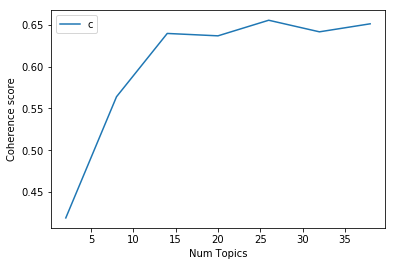

In [20]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4191
Num Topics = 8  has Coherence Value of 0.5639
Num Topics = 14  has Coherence Value of 0.6396
Num Topics = 20  has Coherence Value of 0.6367
Num Topics = 26  has Coherence Value of 0.6553
Num Topics = 32  has Coherence Value of 0.6415
Num Topics = 38  has Coherence Value of 0.6511


In [22]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.026*"car" + 0.011*"good" + 0.008*"power" + 0.007*"buy" + 0.006*"ground" + '
  '0.006*"engine" + 0.005*"wire" + 0.005*"work" + 0.005*"low" + 0.005*"high"'),
 (1,
  '0.039*"window" + 0.034*"problem" + 0.033*"line" + 0.018*"organization" + '
  '0.016*"driver" + 0.015*"run" + 0.013*"work" + 0.011*"color" + '
  '0.009*"screen" + 0.009*"find"'),
 (2,
  '0.854*"ax" + 0.062*"max" + 0.002*"tm" + 0.002*"qax" + 0.001*"_" + '
  '0.001*"giz" + 0.001*"mf" + 0.001*"ml" + 0.001*"fp" + 0.001*"gq"'),
 (3,
  '0.055*"_" + 0.023*"line" + 0.015*"organization" + 0.015*"ca" + 0.006*"air" '
  '+ 0.006*"cx" + 0.004*"md" + 0.004*"ad" + 0.004*"mo" + 0.004*"ms"'),
 (4,
  '0.021*"post" + 0.019*"information" + 0.019*"mail" + 0.016*"send" + '
  '0.014*"list" + 0.014*"group" + 0.013*"address" + 0.010*"include" + '
  '0.010*"internet" + 0.009*"book"'),
 (5,
  '0.017*"time" + 0.015*"people" + 0.011*"start" + 0.011*"day" + '
  '0.011*"happen" + 0.009*"leave" + 0.009*"line" + 0.008*"hear" + '
  '0.008*"thing" + 

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1468,"car, good, power, buy, ground, engine, wire, w...",From: (wheres my thing) Subject: WHAT car is t...
1,1,8.0,0.1728,"drive, system, card, scsi, mac, bit, disk, com...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,13.0,0.2951,"good, organization, line, bike, make, back, wr...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,12.0,0.2844,"file, program, image, version, server, softwar...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,1.0,0.2449,"window, problem, line, organization, driver, r...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,0.0,0.3539,"car, good, power, buy, ground, engine, wire, w...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,7.0,0.1207,"write, article, organization, line, post, repl...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,4.0,0.1574,"post, information, mail, send, list, group, ad...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,5.0,0.1405,"time, people, start, day, happen, leave, line,...",Subject: Re: Dont more innocents die without t...
9,9,11.0,0.3119,"god, christian, people, make, word, question, ...",From: (Jon Livesey) Subject: Re: Genocide is C...


In [24]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7601,"car, good, power, buy, ground, engine, wire, w...","From: Subject: Grounding power wiring, was Re:..."
1,1.0,0.6806,"window, problem, line, organization, driver, r...",From: (Bradley T Banko) Subject: Save my hard ...
2,2.0,0.9958,"ax, max, tm, qax, _, giz, mf, ml, fp, gq",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
3,3.0,0.9806,"_, line, organization, ca, air, cx, md, ad, mo...",Subject: roman 02/14 From: (Cliff) Reply-To: (...
4,4.0,0.6674,"post, information, mail, send, list, group, ad...",From: (Robert Lipman) Subject: CALL FOR PRESEN...


In [25]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"car, good, power, buy, ground, engine, wire, w...",887.0,0.0784
1,8.0,"drive, system, card, scsi, mac, bit, disk, com...",818.0,0.0723
2,13.0,"good, organization, line, bike, make, back, wr...",10.0,0.0009
3,12.0,"file, program, image, version, server, softwar...",134.0,0.0118
4,1.0,"window, problem, line, organization, driver, r...",309.0,0.0273
5,0.0,"car, good, power, buy, ground, engine, wire, w...",133.0,0.0118
6,7.0,"write, article, organization, line, post, repl...",663.0,0.0586
7,4.0,"post, information, mail, send, list, group, ad...",440.0,0.0389
8,5.0,"time, people, start, day, happen, leave, line,...",1140.0,0.1008
9,11.0,"god, christian, people, make, word, question, ...",1026.0,0.0907
